# CNNs for Face Identification 

We will perform face identification using a subset of the [Labeled Faces in the Wild (LFW) dataset](http://vis-www.cs.umass.edu/lfw/). Face identification is a multi-class calssification problem where we have training/testing images for a set of subjects (classes). In 2014, researchers were able to surpass human accuracy in facial identification tasks using CNN models (along with advanced deep learning techniques)! 

We will observe the performance of a traditional face identification method, [Eigenfaces](https://en.wikipedia.org/wiki/Eigenface). We will then build a CNN model in order to surpass the accuracy of the traditional Eigenfaces technique. In the process, we will learn about the great power of CNNs!

### Requirements

1. Python 3.6
2. `pip install numpy`
3. `pip install sklearn`
4. `pip install matplotlib`
5. `pip install tensorflow==2.0.0`

In [1]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Activation, Conv2D, MaxPool2D, AveragePooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
import matplotlib.pyplot as plt

np.random.seed(42)
tf.random.set_seed(42)

Let's start by downloading and setting up a subset of the aligned and segmented version of the LFW dataset. We will only get subjects with at least 20 corresponding images. We will also get the grayscale versions of the images. This may take a few minutes . . .

In [2]:
data_x, data_y = fetch_lfw_people(min_faces_per_person=20, color=False, return_X_y=True)
# normalize pixel values to [0,1]
data_x = data_x / 255.

The downloaded `data_x` will be the flattened vector representation of the images. 

We will reshape the vector respresentations back into the original grayscale images and store the images back in `data_x`.

In [3]:
num_subjects = np.unique(data_y).shape[0]
print("Number of subjects: {}".format(np.unique(data_y).shape[0]))
print("Number of images: {}\n".format(data_y.shape[0]))

# image_x will contain the original grayscale images 
data_x = np.copy(data_x.reshape((data_x.shape[0], 62, 47, 1)))

print("data_x shape: {}".format(data_x.shape))
print("data_y shape: {}".format(data_y.shape))

Number of subjects: 62
Number of images: 3023

data_x shape: (3023, 62, 47, 1)
data_y shape: (3023,)


As we can see, the dataset is made up of `3023` images of `62` subjects (or classes). 

Each image is a `62x47x1`-dimensional matrix containing 8-bit (0-255) grayscale pixel values.

Let's visualize a few of the grayscale images.

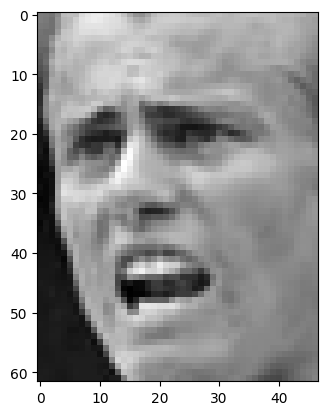

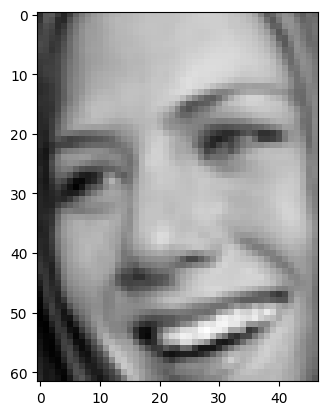

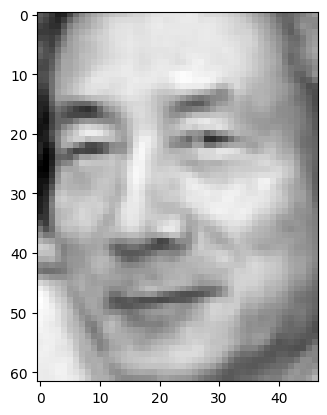

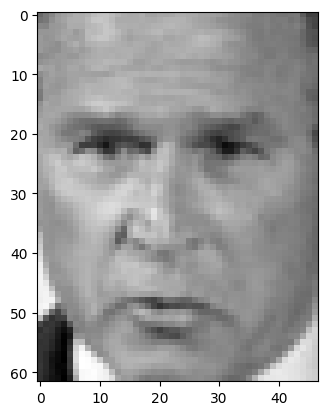

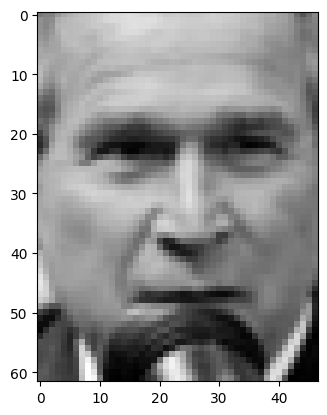

In [4]:
np.random.seed(42)
for i in range(5):
    rnd_idx = np.random.choice(data_y.shape[0])
    rnd_img = data_x[rnd_idx]
    plt.figure()
    plt.imshow(rnd_img[:, :, 0], cmap="gray")

Now, let's split the dataset into train and test sets so we can perform face identification!

We will perform a `90/10` stratified split. This means that `90%` of each subject's images are placed in the train set, while the remaining `10%` of each subject's images are placed into the test set. 

In [5]:
train_x, test_x, train_y, test_y = train_test_split(data_x, data_y, test_size=0.1, random_state=42)

print("train_x shape: {}".format(train_x.shape))
print("train_y shape: {}\n".format(train_y.shape))

print("test_x shape: {}".format(test_x.shape))
print("test_y shape: {}".format(test_y.shape))

train_x shape: (2720, 62, 47, 1)
train_y shape: (2720,)

test_x shape: (303, 62, 47, 1)
test_y shape: (303,)


### Eigenfaces Overview

Eigenfaces is a face identification technique proposed in 1987. It was a very popular algorithm through the 1990's and is still used today as a baseline algorithm when gauging the performance of proposed face identification techniques. Eigenfaces is used to extract features from facial images. Such facial features are more useful in identification tasks than the corresponding oringinal images. The facial features can then be used for identification by being classified by a multi-class classifier, such a logistic regression model. 

### Eigenfaces Details

Eigenfaces is a Principcal Componet Analysis (PCA)-based dimensionality-reduction technique. Eigenfaces deals with the flattened vector representations of the face images. 

We give the vector representation of the training images as input to the algorithm. The output of the algoirthm is a set of Eigenfaces (vectors) which we can use to project vector representations of images into a lower-dimensional space which (hopefully) encode important facial features. 

Since the lower-dimensional space captures important facial features, Eigenfaces is used as a feature extraction technique. Given a facial image, we can reshape the image into a vector. Using the Eigenfaces, we reduce the dimensionality of the original vector into a vector which is more useful in identifying its corresponging subject. Therefore, we will use the Eigenfaces to extract facial features. Then, we will use a simple logistic regression classifier to classify the resulting facial features.

Let's start by flattening the training facial images. Then we will continue by computing the Eigenfaces which capture `95%` of the variance of the original dataset.

In [6]:
# flatten images 
train_vector_x = train_x.reshape((train_x.shape[0], train_x.shape[1]*train_x.shape[2])) 
test_vector_x = test_x.reshape((test_x.shape[0], test_x.shape[1]*test_x.shape[2])) 

# retrieve eigenfaces
pca = PCA(n_components=0.95, random_state=42)
pca.fit(train_vector_x)
eigenfaces = pca.components_

print("Training vectors shape: {}".format(train_vector_x.shape))
print("Eigenfaces shape: {}".format(eigenfaces.shape))

Training vectors shape: (2720, 2914)
Eigenfaces shape: (202, 2914)


As we see, if we flatten the training images to gather their vector representations, we recieve `2720` vectors of size `2914`. We also see that we have found `173` Eigenfaces vectors of size `2914`.

If we reshape the set of Eigenfaces to the shape of the original images, they reveal intesting ghost faces (i.e. "Eigenfaces").

Let's view the first `10` Eigenfaces.

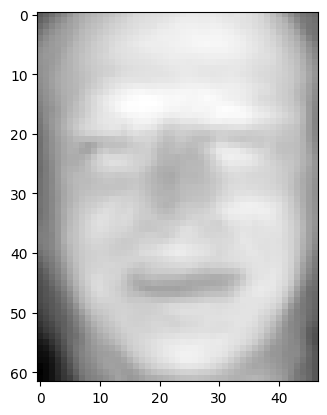

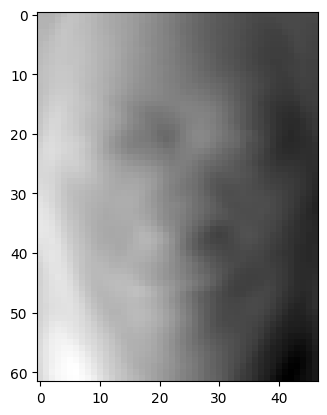

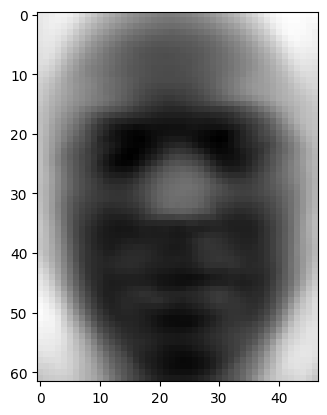

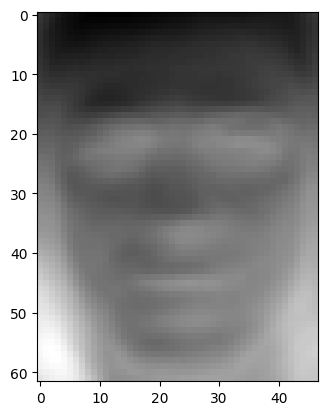

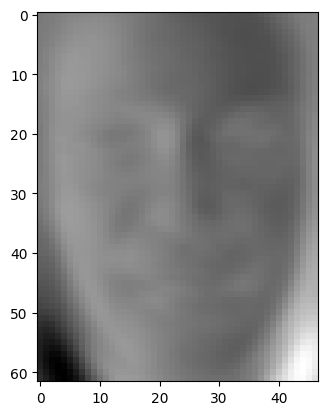

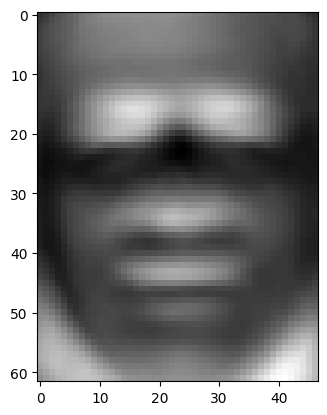

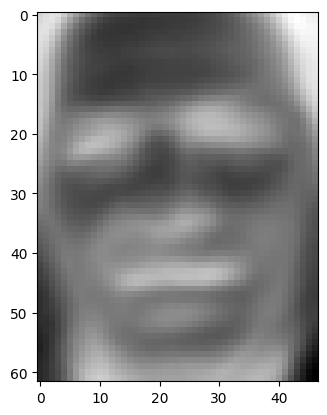

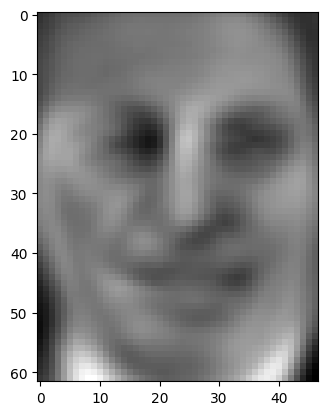

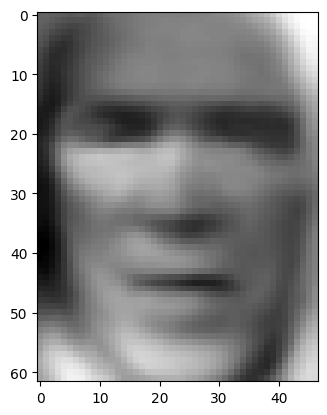

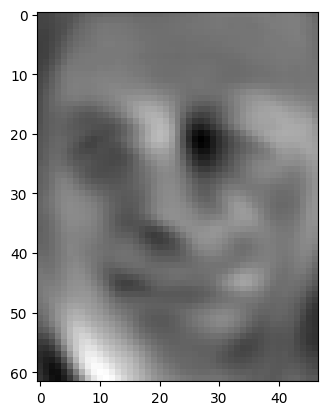

In [7]:
for i in range(10):
    eigenface = eigenfaces[i].reshape((train_x.shape[1], train_x.shape[2]))
    plt.figure()
    plt.imshow(eigenface, cmap="gray")

Spooky!

Now, let's use the Eigenfaces to extract facial features from the training and test set vectors. Since we have `173` Eigenfaces, we will reduce the dimensionality of the `2914`-dimensional train/test vectors to `173`-dimensional train/test feature vectors.

In [8]:
train_features_x = np.dot(train_vector_x, eigenfaces.T)
test_features_x = np.dot(test_vector_x, eigenfaces.T)

print("Training vectors shape: {}".format(train_vector_x.shape))
print("Training features shape: {}".format(train_features_x.shape))
print("Testing vectors shape: {}".format(test_vector_x.shape))
print("Testing features shape: {}".format(test_features_x.shape))

Training vectors shape: (2720, 2914)
Training features shape: (2720, 202)
Testing vectors shape: (303, 2914)
Testing features shape: (303, 202)


Great! Now that we have extracted facial features from the train and testing set, let's perform facial identification using a simple logistic regression model!

In [9]:
# specify the input size of the feature vectors
features = Input((train_features_x.shape[1],))
# a single fully-connected layer to map the features to a logit vector with one logit per subject
x = Dense(num_subjects)(features)
# use softmax activation to convert the logits to class probabilities for each subject
predictions = Activation("softmax")(x)

# create the model using the layers we defined previously
logistic_regression = Model(inputs=features, outputs=predictions)

# compile the model so that it uses Adam for optimization during training with cross-entropy loss
logistic_regression.compile(optimizer=Adam(), loss="sparse_categorical_crossentropy", metrics=["acc"])

# print out a summary of the model achitecture
print(logistic_regression.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 202)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 62)             │        12,586 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 62)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,586 (49.16 KB)

 Trainable params: 12,586 (49.16 KB)

 Non-trainable params: 0 (0.00 B)

None


In [10]:
# since the subjects have different numbers of images, 
# we need to balance how much each subject contributes to the cross-entropy loss
class_weights = compute_class_weight("balanced", classes = np.unique(train_y), y = train_y)

# Convert to dictionary format (required for sklearn models)
class_weights = dict(zip(np.unique(train_y), class_weights))

# train model, verbose set to 0 to supress output, wait a moment for training to complete
logistic_regression.fit(train_features_x, train_y, validation_data=(test_features_x, test_y), 
                        class_weight=class_weights, 
                        epochs=75, batch_size=128, verbose=0)

# evaluate model, get train/test accuracy
train_eig_pred = np.argmax(logistic_regression.predict(train_features_x), axis=1)
test_eig_pred = np.argmax(logistic_regression.predict(test_features_x), axis=1)
print("\nTraining accuracy using Eigenfaces and logistic regression model: {}".format(accuracy_score(train_y, train_eig_pred)))
print("Testing accuracy using Eigenfaces and logistic regression model: {}".format(accuracy_score(test_y, test_eig_pred)))

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Training accuracy using Eigenfaces and logistic regression model: 0.057352941176470586
Testing accuracy using Eigenfaces and logistic regression model: 0.033003300330033


# Your turn!

### Sample CNN Model
The Eigenfaces and logistic regression model doesn't perform that well on the unseen test set. Let's see how a simple CNN model compares.

Rather than dealing with vectors, we will begin working with the grayscale images directly. 

Remember that a CNN learns convolution filters which extract the most useful features. Then, a small neural network at the end of the CNN architecture performs the multi-class classification. Therefore, the CNN will make things less complex for us as the CNN will learn to perform both feature extraction and classification! 

<b> Complete the section below</b>

In [11]:
# specify the input size of the images
images = Input((train_x.shape[1], train_x.shape[2], 1,))
# a convolution layer of 32 filters of size 9x9 to extract features (valid padding)
x = Conv2D(32, (9,9), padding="valid")(images)
# a maxpooling layer to down-sample features with pool size (2, 2)
x = MaxPool2D((2,2))(x)

# another convolution layer of 64 filters of size 11x11 to extract features (valid padding)
x = Conv2D(64, (11,11), padding="valid")(x)
# a maxpooling layer to down-sample features with pool size (2, 2)
x = MaxPool2D((2,2))(x)

# flatten extracted features to form feature vector
x = Flatten()(x)
# a drop out layer for regularization (25% probability)
x = Dropout(rate=0.25)(x)
# first fully-connected layer to map the features to vectors of size 256
x = Dense(256, activation=tf.nn.relu)(x)
# anoter drop out layer for regularization (25% probability)
x = Dropout(rate=0.25)(x)
# a second fully-connected layer to map the features to a logit vector with one logit per subject
x = Dense(num_subjects)(x)
# use softmax activation to convert the logits to class probabilities for each subject
predictions = Activation("softmax")(x)

# create the model using the layers we defined previously
sample_cnn = Model(inputs=images, outputs=predictions)

# compile the model so that it uses Adam for optimization during training with cross-entropy loss
sample_cnn.compile(optimizer=Adam(), loss="sparse_categorical_crossentropy", metrics=["acc"])

# print out a summary of the model achitecture
print(sample_cnn.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 62, 47, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 54, 39, 32)     │         2,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 27, 19, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 17, 9, 64)      │       247,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 62)             │        15,934 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 62)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 790,974 (3.02 MB)

 Trainable params: 790,974 (3.02 MB)

 Non-trainable params: 0 (0.00 B)

None


In [12]:
# since the subjects have different numbers of images, 
# we need to balance how much each subject contributes to the cross-entropy loss
class_weights = compute_class_weight("balanced", classes = np.unique(train_y), y = train_y)

# Convert to dictionary format (required for sklearn models)
class_weights = dict(zip(np.unique(train_y), class_weights))

# train model
sample_cnn.fit(train_x, train_y, validation_data=(test_x, test_y), 
               class_weight=class_weights, 
               epochs=15, batch_size=64, verbose=1)

# evaluate model, get train/test accuracy
train_pred = np.argmax(sample_cnn.predict(train_x), axis=1)
test_pred = np.argmax(sample_cnn.predict(test_x), axis=1)
print("\nTraining accuracy using sample CNN model: {}".format(accuracy_score(train_y, train_pred)))
print("Testing accuracy using sample CNN model: {}\n".format(accuracy_score(test_y, test_pred)))

print("The sample CNN model beat the Eigenfaces and logistic regression model! :)")
print("Training accuracy using Eigenfaces and logistic regression model: {}".format(accuracy_score(train_y, train_eig_pred)))
print("Testing accuracy using Eigenfaces and logistic regression model: {}".format(accuracy_score(test_y, test_eig_pred)))

Epoch 1/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - acc: 0.0102 - loss: 4.1557 - val_acc: 0.0099 - val_loss: 4.1352
Epoch 2/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - acc: 0.0137 - loss: 4.1502 - val_acc: 0.0099 - val_loss: 4.1327
Epoch 3/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - acc: 0.0077 - loss: 4.1684 - val_acc: 0.0033 - val_loss: 4.1393
Epoch 4/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - acc: 0.0112 - loss: 4.1569 - val_acc: 0.0066 - val_loss: 4.1547
Epoch 5/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - acc: 0.0144 - loss: 4.1770 - val_acc: 0.0066 - val_loss: 4.1551
Epoch 6/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - acc: 0.0094 - loss: 4.1826 - val_acc: 0.0000e+00 - val_loss: 4.2594
Epoch 7/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - acc: 0.0173 - loss: 4.1518 - val_acc: 0.0066 - val_loss: 4.1038
Epoch 8/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - acc: 0.0112 - loss: 4.1690 - val_acc: 0.0165 - val_loss: 4.1224
Epoch 9/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - acc: 

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.utils import to_categorical

In [14]:
# Load dataset
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
X = lfw_people.images
y = lfw_people.target

# Split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
n_classes = len(np.unique(y))

# Normalize images
X_train = X_train / 255.0
X_test = X_test / 255.0

y_train = to_categorical(y_train, num_classes=n_classes)
y_test = to_categorical(y_test, num_classes=n_classes)

In [15]:
X.shape

(1288, 50, 37)

In [16]:
# Model 1
model1 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(50, 37, 1)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(n_classes, activation='softmax')
])
print(model1.summary())

/opt/miniconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 48, 35, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 24, 17, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 13056)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │     1,671,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,672,519 (6.38 MB)

 Trainable params: 1,672,519 (6.38 MB)

 Non-trainable params: 0 (0.00 B)

None


In [17]:
model1.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model1.fit(X_train[..., np.newaxis], y_train, epochs=12, batch_size=32, verbose=1)

Epoch 1/12
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3538 - loss: 1.8242
Epoch 2/12
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4031 - loss: 1.7046
Epoch 3/12
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4031 - loss: 1.7011
Epoch 4/12
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4031 - loss: 1.7008
Epoch 5/12
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4031 - loss: 1.7003
Epoch 6/12
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4031 - loss: 1.6999
Epoch 7/12
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4031 - loss: 1.6996
Epoch 8/12
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4031 - loss: 1.6991
Epoch 9/12
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4031 - loss: 1.6986
Epoch 10/12
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4031 - loss: 1.6982
Epoch 11/12
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4031 - loss: 1.6976
Epoch 12/12
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy:

In [18]:
# Evaluate test accuracy
test_accuracy = model1.evaluate(X_test[..., np.newaxis], y_test, verbose=1)[1]
print("Test Accuracy of Model 1:", test_accuracy)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5007 - loss: 1.5304 
Test Accuracy of Model 1: 0.46124032139778137


### Model 2

In [19]:
# Model 2
model2 = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(50, 37, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(n_classes, activation='softmax')
])

print(model2.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 48, 35, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 24, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 22, 15, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 11, 7, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4928)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │       630,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 669,383 (2.55 MB)

 Trainable params: 669,383 (2.55 MB)

 Non-trainable params: 0 (0.00 B)

None


In [20]:
model2.compile(optimizer=RMSprop(), loss='categorical_crossentropy', metrics=['accuracy'])
model2.fit(X_train[..., np.newaxis], y_train, epochs=12, batch_size=32, verbose=1)

Epoch 1/12
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.3501 - loss: 1.8232
Epoch 2/12
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4031 - loss: 1.7105
Epoch 3/12
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4031 - loss: 1.7085
Epoch 4/12
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4031 - loss: 1.7072
Epoch 5/12
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4031 - loss: 1.7062
Epoch 6/12
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.4031 - loss: 1.7051
Epoch 7/12
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4031 - loss: 1.7044
Epoch 8/12
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4031 - loss: 1.7038
Epoch 9/12
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4031 - loss: 1.7033
Epoch 10/12
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.4031 - loss: 1.7027
Epoch 11/12
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4031 - loss: 1.7022
Epoch 12/12
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy:

In [21]:
# Evaluate test accuracy
test_accuracy = model2.evaluate(X_test[..., np.newaxis], y_test, verbose=1)[1]
print("Test Accuracy of Model 2:", test_accuracy)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5007 - loss: 1.5218 
Test Accuracy of Model 2: 0.46124032139778137


### Model 3

In [22]:
# Model 3
model3 = Sequential([
    Conv2D(32, (5, 5), activation='relu', input_shape=(50, 37, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(n_classes, activation='softmax')
])

print(model3.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 46, 33, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 23, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 21, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 10, 7, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 5, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 4, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,287 (880.03 KB)

 Trainable params: 225,287 (880.03 KB)

 Non-trainable params: 0 (0.00 B)

None


In [23]:
model3.compile(optimizer=SGD(), loss='categorical_crossentropy', metrics=['accuracy'])
model3.fit(X_train[..., np.newaxis], y_train, epochs=12, batch_size=32, verbose=1)

Epoch 1/12
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3652 - loss: 1.9331
Epoch 2/12
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4031 - loss: 1.8808
Epoch 3/12
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4031 - loss: 1.8336
Epoch 4/12
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4031 - loss: 1.7910
Epoch 5/12
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4031 - loss: 1.7537
Epoch 6/12
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4031 - loss: 1.7254
Epoch 7/12
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4031 - loss: 1.7088
Epoch 8/12
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4031 - loss: 1.7015
Epoch 9/12
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4031 - loss: 1.6984
Epoch 10/12
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4031 - loss: 1.6969
Epoch 11/12
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4031 - loss: 1.6959
Epoch 12/12
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy:

In [24]:
# Evaluate test accuracy
test_accuracy = model3.evaluate(X_test[..., np.newaxis], y_test, verbose=1)[1]
print("Test Accuracy of Model 3:", test_accuracy)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5007 - loss: 1.5436 
Test Accuracy of Model 3: 0.46124032139778137


### Model 4

In [32]:
# Model 4 (CNN achieving ~80% accuracy)
model4 = Sequential([
    Conv2D(128, (3, 3), activation='relu', input_shape=(50, 37, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(n_classes, activation='softmax')
])

print(model4.summary())

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 48, 35, 128)    │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 48, 35, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 24, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 24, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 22, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 22, 15, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 11, 7, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 11, 7, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 19712)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │     5,046,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,346,311 (20.39 MB)

 Trainable params: 5,345,543 (20.39 MB)

 Non-trainable params: 768 (3.00 KB)

None


In [35]:
model4.compile(optimizer=RMSprop(), loss='categorical_crossentropy', metrics=['accuracy'])
model4.fit(X_train[..., np.newaxis], y_train, epochs=5, batch_size=64, verbose=1)

Epoch 1/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 245ms/step - accuracy: 0.4684 - loss: 1.5346
Epoch 2/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 250ms/step - accuracy: 0.6055 - loss: 1.1566
Epoch 3/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 257ms/step - accuracy: 0.6610 - loss: 1.0175
Epoch 4/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 257ms/step - accuracy: 0.7355 - loss: 0.7807
Epoch 5/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 258ms/step - accuracy: 0.7773 - loss: 0.5888


In [36]:
# Evaluate test accuracy
test_accuracy = model4.evaluate(X_test[..., np.newaxis], y_test, verbose=1)[1]
print("Test Accuracy of Model 4:", test_accuracy)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.1765 - loss: 1.9284
Test Accuracy of Model 4: 0.1821705400943756


### Some identified images

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


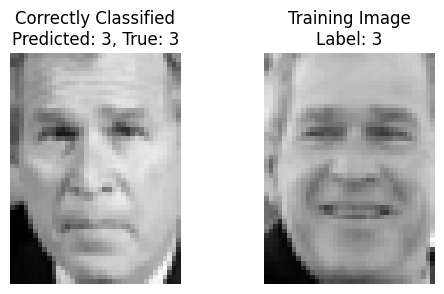

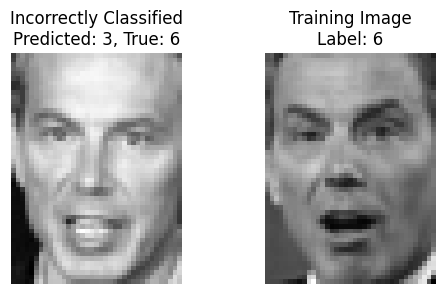

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Get model predictions
predictions = np.argmax(model4.predict(X_test[..., np.newaxis]), axis=1)
true_labels = np.argmax(y_test, axis=1)  # Convert one-hot labels back to categorical

# Find correctly and incorrectly classified samples
correct_indices = np.where(predictions == true_labels)[0]
incorrect_indices = np.where(predictions != true_labels)[0]

# Select first correctly classified sample
if len(correct_indices) > 0:
    correct_idx = correct_indices[0]
    correct_label = true_labels[correct_idx]
    
    # Find a training image of the same subject
    train_subject_indices = np.where(np.argmax(y_train, axis=1) == correct_label)[0]
    train_img_idx = train_subject_indices[0] if len(train_subject_indices) > 0 else None
    
    # Display the images
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(X_test[correct_idx], cmap='gray')
    plt.title(f"Correctly Classified\nPredicted: {predictions[correct_idx]}, True: {correct_label}")
    plt.axis('off')

    if train_img_idx is not None:
        plt.subplot(1, 2, 2)
        plt.imshow(X_train[train_img_idx], cmap='gray')
        plt.title(f"Training Image\nLabel: {correct_label}")
        plt.axis('off')

    plt.show()

# Select first incorrectly classified sample
if len(incorrect_indices) > 0:
    incorrect_idx = incorrect_indices[0]
    incorrect_label = true_labels[incorrect_idx]
    predicted_label = predictions[incorrect_idx]
    
    # Find a training image of the correct subject
    train_subject_indices = np.where(np.argmax(y_train, axis=1) == incorrect_label)[0]
    train_img_idx = train_subject_indices[0] if len(train_subject_indices) > 0 else None
    
    # Display the images
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(X_test[incorrect_idx], cmap='gray')
    plt.title(f"Incorrectly Classified\nPredicted: {predicted_label}, True: {incorrect_label}")
    plt.axis('off')

    if train_img_idx is not None:
        plt.subplot(1, 2, 2)
        plt.imshow(X_train[train_img_idx], cmap='gray')
        plt.title(f"Training Image\nLabel: {incorrect_label}")
        plt.axis('off')

    plt.show()